## Problem Set 5
## Dr. Rick Evans
## February 22, 2018
### Kevin Sun

### 1.) Multinomial logistic regression and cross validation

In [13]:
# import relevant libraries
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut, KFold
import statsmodels.api as sm
import scipy.interpolate as intpl
%matplotlib inline

# import data
booze = pd.read_csv('data/strongdrink.txt')
booze.head(5)

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [14]:
# drop columns we are not using
booze = booze.drop(['ash', 'alk','magn','flav', 'nonfl_phen', 'proanth', 'hue', 'OD280rat', 'proline'], 1)

#### 1a)

In [15]:
X = booze[['alco', 'malic', 'tot_phen', 'color_int']]
y = booze[['cultivar']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=20)

MultLogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
MultLogReg.fit(X_train, y_train)

/Users/kevinsun/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
y_pred = MultLogReg.predict(X_test)
y_pred

array([2, 3, 1, 2, 2, 1, 3, 2, 2, 3, 1, 3, 2, 1, 1, 2, 2, 1, 1, 3, 3, 1, 2,
       1, 3, 2, 1, 3, 2, 2, 2, 2, 3, 2, 1, 1, 1, 2, 3, 2, 1, 1, 2, 2])

In [17]:
print("Estimated Coefficients:")
print()
print(MultLogReg.intercept_)
print()
print(MultLogReg.coef_)

Estimated Coefficients:

[-24.01126827  22.80207972   1.20918855]

[[ 1.70042635 -0.26560786  1.22389489  0.02275125]
 [-1.46801585 -0.33305182  0.66400741 -0.92271036]
 [-0.2324106   0.59865966 -1.8879023   0.89995911]]


The estimated coefficients for j = 1 are -24.011, 1.7, -0.266, 1.224, 0.023. The estimated coefficients for j = 2 are -1.468, -0.333, 0.664, -0.923.

In [18]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



Our error rates for each cultivar is as follows:

0.13, 0.0, 0.0 for cultivars 1, 2, and 3 respectively. Both cultivars 2 and 3 had equal precision levels. However, since category 3 has a higher recall rate it is the most accurately predicted category despite having the fewest observations. 

#### 1b) Leave One Out (LOO)

In [19]:
booze.head()

,cultivar,alco,malic,tot_phen,color_int
0,1,14.23,1.71,2.80,5.64
1,1,13.20,1.78,2.65,4.38
2,1,13.16,2.36,2.80,5.68
3,1,14.37,1.95,3.85,7.80
4,1,13.24,2.59,2.80,4.32


In [26]:
Xvars = booze[['alco', 'malic', 'tot_phen', 'color_int']].values
yvals = booze["cultivar"].values
N_loo = Xvars.shape[0]

#create empty LOO object
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
error_df = pd.DataFrame({"error": np.zeros(N_loo), "y_test": np.zeros(N_loo), "y_pred": np.zeros(N_loo)})

In [27]:
for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    MultLogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    MultLogReg.fit(X_train, y_train)
    y_pred = MultLogReg.predict(X_test)
    error_df["y_test"][test_index] = y_test
    error_df["y_pred"][test_index] = y_pred
    error_df["error"][test_index] = (error_df["y_test"][test_index] != \
                                     error_df["y_pred"][test_index]).astype(int)

In [30]:
print('test estimate MSE_loocv=', error_df["error"].mean())
print()
print(classification_report(y_test_vec, y_pred_vec))

test estimate MSE_loocv= 0.07954545454545454

cultivar = 1 error: 0.09836065573770492
cultivar = 2 error: 0.08571428571428572
cultivar = 3 error: 0.044444444444444446


The error rates overall for LOO are larger. This is not a better predictor as they are higher than what we had in part a.

#### 1c) K-folds

In [38]:
X = booze[['alco', 'malic', 'tot_phen', 'color_int']].values
y = booze['cultivar'].values
k=4
kf = KFold(n_splits=k, shuffle=True, random_state=10)
kf.get_n_splits(X)
MSE_vec_kf = np.zeros(k)
y_test_vec = np.array([])
y_pred_vec = np.array([])

k_ind = int(0)
for train_index, test_index in kf.split(X):
    print('k index=', k_ind)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_test_vec = np.append(y_test_vec, y_test)
    LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    y_pred_vec = np.append(y_pred_vec, y_pred)
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

k index= 0
MSE for test set 0  is 0.227272727273
k index= 1
MSE for test set 1  is 0.113636363636
k index= 2
MSE for test set 2  is 0.0454545454545
k index= 3
MSE for test set 3  is 0.0454545454545
test estimate MSE k-fold= 0.107954545455 test estimate MSE standard err= 0.0742994138104


Again, the error rates are higher than in parts a and b.

### 2.) Spline and kernal density interpolation

In [122]:
# import data
col_names = ['age', 'cool_score']
cool = pd.read_csv('data/CoolIndex.txt', header=None, names=col_names)
cool.head(5)

,age,cool_score
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


#### 2a) Scatterplot

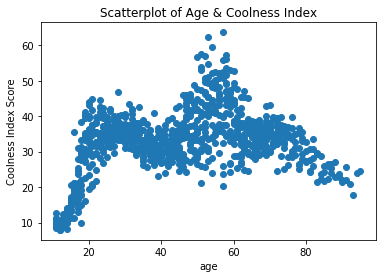

In [123]:
plt.scatter(x=cool['age'], y=cool['cool_score'])
plt.title('Scatterplot of Age & Coolness Index')
plt.xlabel('age')
plt.ylabel('Coolness Index Score')

#### 2b) OLS & Stepwise Function

In [124]:
age = cool['age']
cool_score = cool['cool_score']
#split the data up into bins
age_bin1 = ((age >= 11) & (age < 22)).astype(int) #astype(int) changes from true boolean to 0/1
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = (age >= 77).astype(int)
X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,\
                           age_bin3=age_bin3, age_bin4=age_bin4,\
                          age_bin5=age_bin5))
X_step.describe()

,age_bin1,age_bin2,age_bin3,age_bin4,age_bin5
count,956.000000,956.000000,956.000000,956.000000,956.000000
mean,0.162134,0.276151,0.285565,0.217573,0.058577
std,0.368767,0.447326,0.451919,0.412812,0.234955
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [125]:
reg = sm.OLS(endog=cool_score, exog=X_step, missing='drop')
reg_results = reg.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:             cool_score   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Sun, 18 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        15:21:09   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.562     35.746      0.0

In [126]:
# get the coefficients to plot piecewise function
a1, a2, a3, a4, a5 = reg_results.params
l = [a1, a2, a3, a4, a5]
l

[20.102457252090748,
 34.475788077559386,
 37.635105492449618,
 35.225400040242754,
 27.296378244321282]

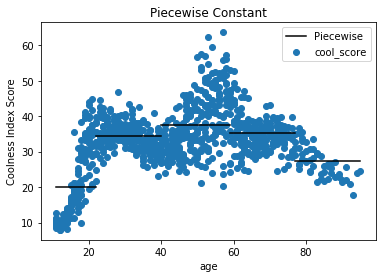

In [127]:
plt.scatter(x=cool['age'], y=cool['cool_score'])
plt.plot([11, 22], [a1, a1], 'k-')
plt.plot([22, 40], [a2, a2], 'k-')
plt.plot([40, 59], [a3, a3], 'k-')
plt.plot([59, 77], [a4, a4], 'k-')
pw = plt.plot([77, 95], [a5, a5], 'k-', label="Piecewise")
plt.title('Piecewise Constant')
plt.xlabel('age')
plt.ylabel('Coolness Index Score')
plt.legend()
plt.show()

In [128]:
print("The predicted coolness of a 73 year-old from this step function is", a4)

The predicted coolness of a 73 year-old from this step function is 35.2254000402


#### 2c) Linear spline

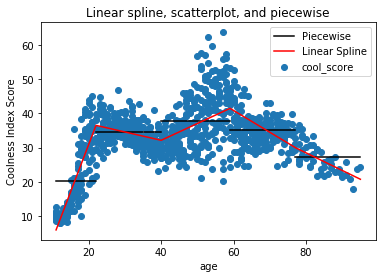

In [129]:
# plot original scatter & piecewise
plt.scatter(x=cool['age'], y=cool['cool_score'])
plt.plot([11, 22], [a1, a1], 'k-')
plt.plot([22, 40], [a2, a2], 'k-')
plt.plot([40, 59], [a3, a3], 'k-')
plt.plot([59, 77], [a4, a4], 'k-')
pw = plt.plot([77, 95], [a5, a5], 'k-', label='Piecewise')


# plot linear spline against scatter and piecewise
knots = [22, 40, 59, 77]
spl = intpl.LSQUnivariateSpline(age.values, cool_score.values, knots, k=1)
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)
linear = plt.plot(age_vec, spl(age_vec), 'r-', label='Linear Spline')

# Give plot labels and show plot
plt.xlabel('age')
plt.ylabel('Coolness Index Score')
plt.title("Linear spline, scatterplot, and piecewise")
plt.legend()
plt.show()

In [130]:
index = [i for i,age in enumerate(age_vec) if age>72.5 and age<73.5 ]
score = []
for i in index:
    score.append(spl(age_vec)[i])
linear_pred = sum(score)/len(score)
print("The predicted coolness of a 73 year-old from the linear spline is", linear_pred)

The predicted coolness of a 73 year-old from the linear spline is 32.5291831125


#### 2d) Cubic spline

In [131]:
print(cool_score.values.shape, age.values.shape)
print(age.describe())

(956,) (956,)
count    956.000000
mean      44.385983
std       20.250954
min       11.000000
25%       27.000000
50%       44.000000
75%       60.000000
max       95.000000
Name: age, dtype: float64


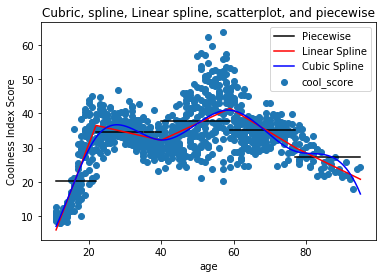

In [132]:
# plot original scatterplot and piecewise function
plt.scatter(x=cool['age'], y=cool['cool_score'])
plt.plot([11, 22], [a1, a1], 'k-')
plt.plot([22, 40], [a2, a2], 'k-')
plt.plot([40, 59], [a3, a3], 'k-')
plt.plot([59, 77], [a4, a4], 'k-')
pw = plt.plot([77, 95], [a5, a5], 'k-', label="Piecewise")


# plot linear spline against scatter and piecewise
knots = [22, 40, 59, 77]
spl = intpl.LSQUnivariateSpline(age.values, cool_score.values, knots, k=1)
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)
linear = plt.plot(age_vec, spl(age_vec), 'r-', label="Linear Spline")


# plot cubric spline
knots = [22, 40, 59, 77]
spl = intpl.LSQUnivariateSpline(age.values, cool_score.values, knots, k=3)
age_vec_cub = np.linspace(age.values.min(), age.values.max(), 1000)
cubic = plt.plot(age_vec_cub, spl(age_vec_cub), 'b-', label="Cubic Spline")

# give plot labels and show plot
plt.xlabel('age')
plt.ylabel('Coolness Index Score')
plt.title("Cubric, spline, Linear spline, scatterplot, and piecewise")
plt.legend()
plt.show()

In [133]:
index_c = [i for i,age in enumerate(age_vec_cub) if age>72.5 and age<73.5 ]
score_c = []
for i in index_c:
    score_c.append(spl(age_vec_cub)[i])
cubic_pred = sum(score_c)/len(score_c)
print("The predicted coolness of a 73 year-old from the cubic spline is", cubic_pred)

The predicted coolness of a 73 year-old from the cubic spline is 31.2561522552
